In [1]:
main_url = 'https://gitlab.in2p3.fr/cornebize/g5k_test/-/raw/master/'
directory = '../data/experiment/non_regression/g5k_test/'
files = {
    'perf': 'stats.csv',
    'monitoring': 'stats_monitoring.csv',
    'changelog': 'exp_changelog.csv',
    'outlierlog': 'exp_outlierlog.csv'
}

In [2]:
for f in files.values():
    path = directory + f
    url = main_url + f
    !wget $url -O $path

!find $directory -name '*csv' | xargs du -sh
!echo
!find $directory -name '*csv' | xargs wc -l

!echo '#############################'

# Let's keep only a subset of the rows (about cluster dahu) and the columns
for name in ['perf', 'monitoring']:
    path = directory + files[name]
    !head -n 1 $path > /tmp/tmp.csv
    !grep "dahu" $path >> /tmp/tmp.csv
    !cut -d, -f6 --complement /tmp/tmp.csv > $path

!find $directory -name '*csv' | xargs du -sh
!echo
!find $directory -name '*csv' | xargs wc -l

--2021-04-26 11:55:37--  https://gitlab.in2p3.fr/cornebize/g5k_test/-/raw/master/stats.csv
Résolution de gitlab.in2p3.fr (gitlab.in2p3.fr)… 134.158.69.41
Connexion à gitlab.in2p3.fr (gitlab.in2p3.fr)|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 94477949 (90M) [text/plain]
Sauvegarde en : « ../data/experiment/non_regression/g5k_test/stats.csv »

../data/experiment/ 100%[===================>]  90,10M  34,0MB/s    ds 2,6s    

2021-04-26 11:55:41 (34,0 MB/s) — « ../data/experiment/non_regression/g5k_test/stats.csv » sauvegardé [94477949/94477949]

--2021-04-26 11:55:41--  https://gitlab.in2p3.fr/cornebize/g5k_test/-/raw/master/stats_monitoring.csv
Résolution de gitlab.in2p3.fr (gitlab.in2p3.fr)… 134.158.69.41
Connexion à gitlab.in2p3.fr (gitlab.in2p3.fr)|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 24750160 (24M) [text/plain]
Sauvegarde en : « ../data/experiment/non_regression/g5k_test/st

In [3]:
import pandas
import plotnine
plotnine.options.figure_size = 10, 7.5
plotnine.options.dpi = 100
from plotnine import *
from cashew import non_regression_tests as nrt
import cashew
print(cashew.__git_version__)

fdff221d3cd29c8dfc91a6c99447316a1e25bb2d


In [4]:
df = nrt.format(nrt.get_path(directory + files['perf']))
changelog = nrt.format_changelog(nrt.get_path(directory + files['changelog']))
outlierlog = nrt.format_changelog(nrt.get_path(directory + files['outlierlog']))

2021-04-26 11:55:46,850 - non_regression_tests - INFO - Loaded a dataframe with 18386 rows and 38 columns
2021-04-26 11:55:46,854 - non_regression_tests - INFO - Loaded a dataframe with 23 rows and 5 columns
2021-04-26 11:55:46,857 - non_regression_tests - INFO - Loaded a dataframe with 41 rows and 5 columns


In [5]:
cluster = 'dahu'
factor = 'mean_gflops'
confidence = 0.9999

In [6]:
df = nrt.filter(df, cluster=cluster)

2021-04-26 11:55:46,878 - non_regression_tests - INFO - Filtered the dataframe, there remains 18386 rows


In [7]:
df = nrt.filter_na(df, factor)

2021-04-26 11:55:46,889 - non_regression_tests - INFO - Filtered the dataframe, there remains 18386 rows


## 1 factor - 1 & 5 day(s)

In [8]:
%%time
marked=nrt.mark_weird(df, changelog, outlierlog, nmin=10, keep=5, window=5, naive=False, confidence=confidence, cols=[factor])
nb_weird = len(marked[marked.weird.isin({'positive', 'negative'})])
nb_total = len(marked[marked.weird != 'NA'])
print(f'{nb_weird/nb_total*100:.2f}% of measures are abnormal ({nb_weird}/{nb_total})')

2.96% of measures are abnormal (457/15420)
CPU times: user 15.8 s, sys: 84.6 ms, total: 15.9 s
Wall time: 15.8 s


In [9]:
from mizani.breaks import date_breaks
from mizani.formatters import date_format

plotnine.options.figure_size = (10, 8)

dahu-14


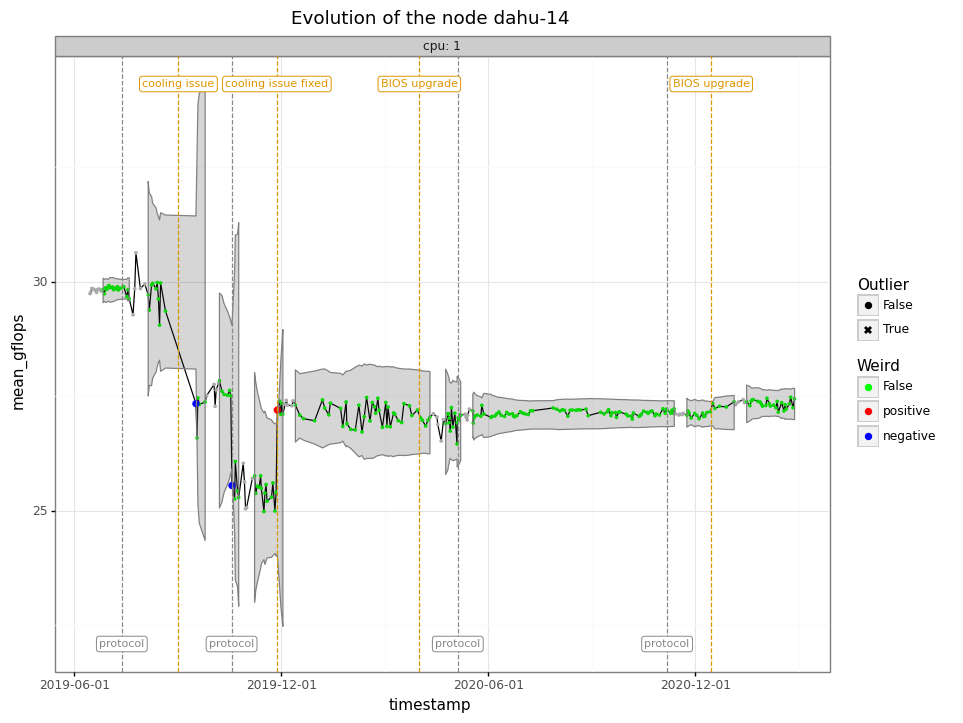

<ggplot: (-9223363292986744723)>
dahu-32


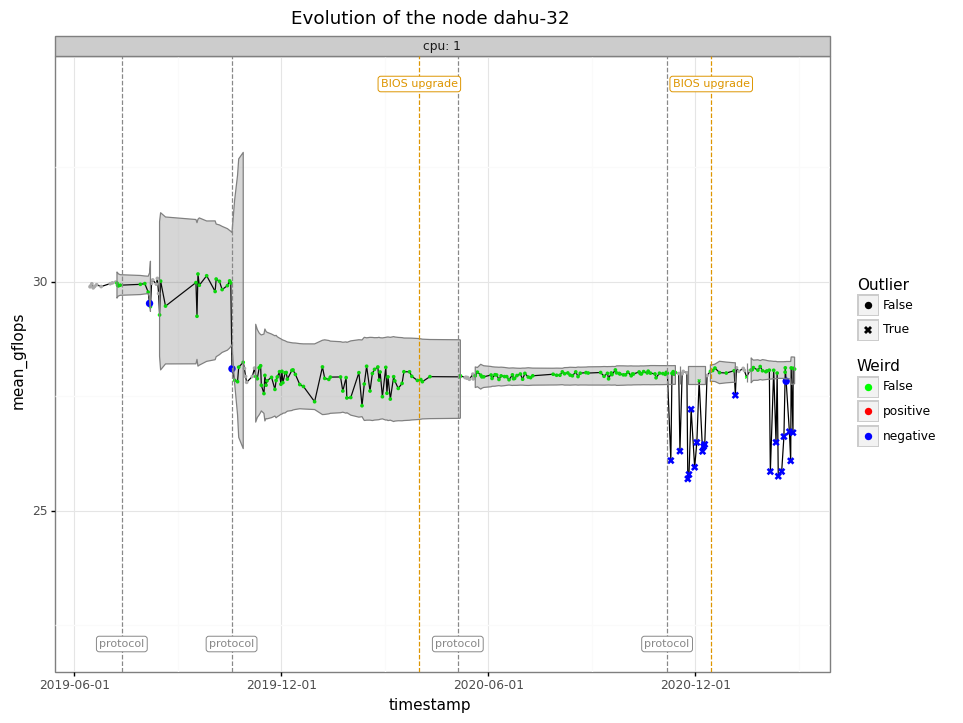

<ggplot: (8743863651413)>


/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 3 in image.
/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../img/slides/evolution_dahu-14.pdf
/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 3 in image.
/home/tom/.cache/pypoetry/virtualenvs/the

In [10]:
max_date = pandas.to_datetime('2021/02/28')
tmp = marked[marked['node'].isin({14, 32})
             & marked['cpu'].isin({1})
             & (marked['timestamp'] < max_date)]
tmp.interest_col = marked.interest_col
plots = nrt.plot_evolution_cluster(tmp, changelog=changelog[changelog['date'] <= max_date])
for hostname, plot in plots.items():
    plot = (plot
        + xlab('Date')
        + ylab('Mean performance (Gflop/s)')
        + scale_x_datetime(breaks=date_breaks('3 months'), labels=date_format('%Y-%m'))
        + theme(strip_background=element_blank(), strip_text_x=element_blank())
        + theme(plot_title=element_blank())
    )
    plot.save(f'../img/slides/evolution_{hostname}.pdf', width=10, height=3)

dahu-14


/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 4 rows containing missing values.
/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


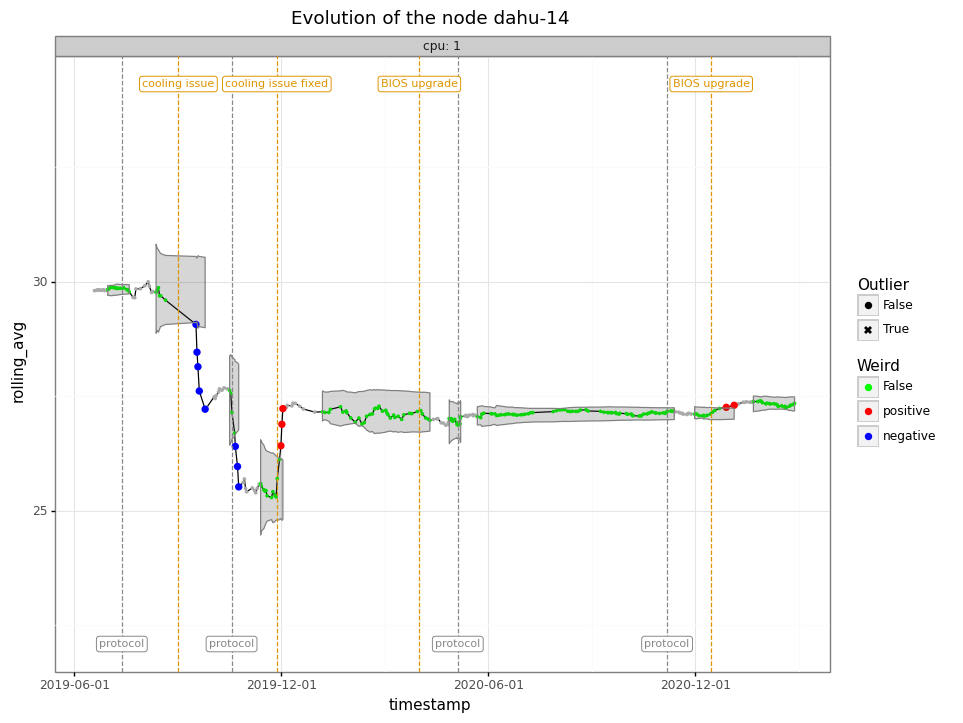

<ggplot: (-9223363292986818146)>
dahu-32


/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 4 rows containing missing values.
/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


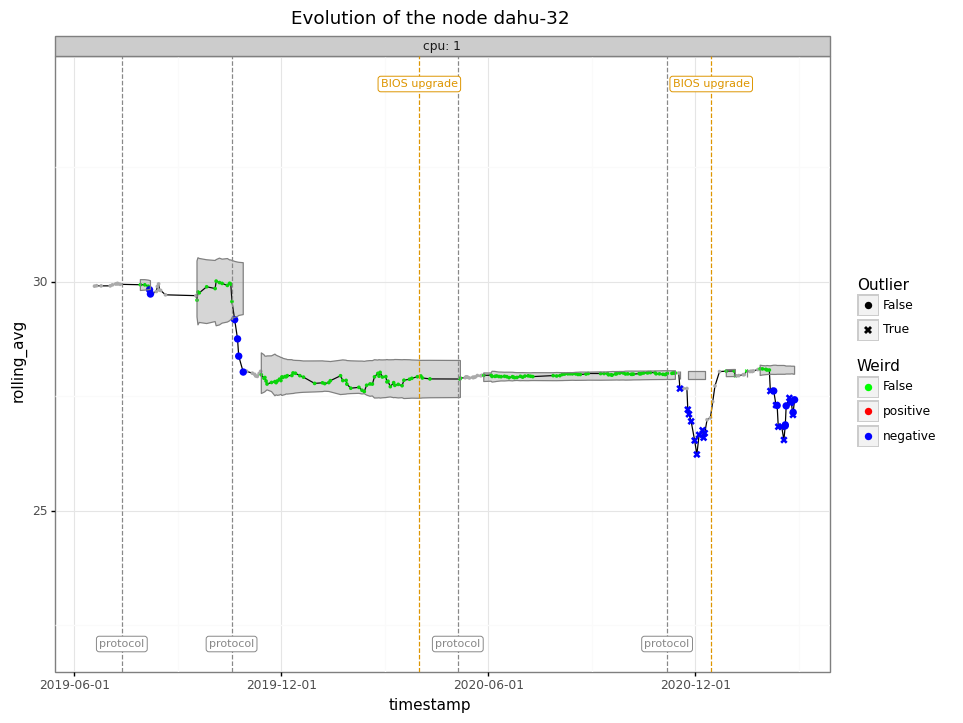

<ggplot: (8743863245232)>


/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 3 in image.
/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../img/slides/evolution_dahu-14_windowed.pdf
/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 4 rows containing missing values.
/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFC

In [11]:
plots = nrt.plot_evolution_cluster_windowed(tmp, changelog=changelog[changelog['date'] <= max_date])
for hostname, plot in plots.items():
    plot = (plot
        + xlab('Date')
        + ylab('Mean performance (Gflop/s)')
        + scale_x_datetime(breaks=date_breaks('3 months'), labels=date_format('%Y-%m'))
        + theme(strip_background=element_blank(), strip_text_x=element_blank())
        + theme(plot_title=element_blank())
    )
    plot.save(f'../img/slides/evolution_{hostname}_windowed.pdf', width=10, height=3)

/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../img/slides/overview_dahu.pdf


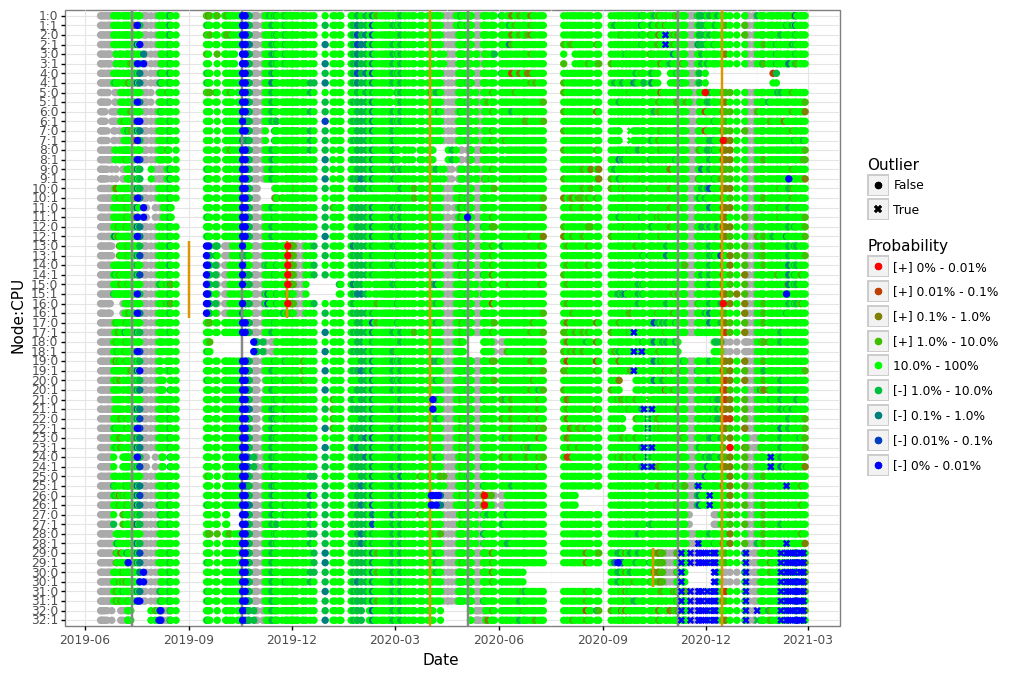

<ggplot: (-9223363292993347079)>

In [12]:
tmp = marked[(marked['timestamp'] < max_date)]
tmp.interest_col = marked.interest_col
tmp.multidim = False
plot = (nrt.plot_overview(tmp, changelog=changelog[changelog['date'] <= max_date], confidence=confidence, discretize=True)
    + xlab('Date')
    + scale_x_datetime(breaks=date_breaks('3 months'), labels=date_format('%Y-%m'))
    + theme(plot_title=element_blank())
)

plot.save('../img/slides/overview_dahu.pdf', width=10, height=8)
plot

/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
/home/tom/.cache/pypoetry/virtualenvs/thesis-rcFnFCer-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../img/slides/overview_windowed_dahu.pdf


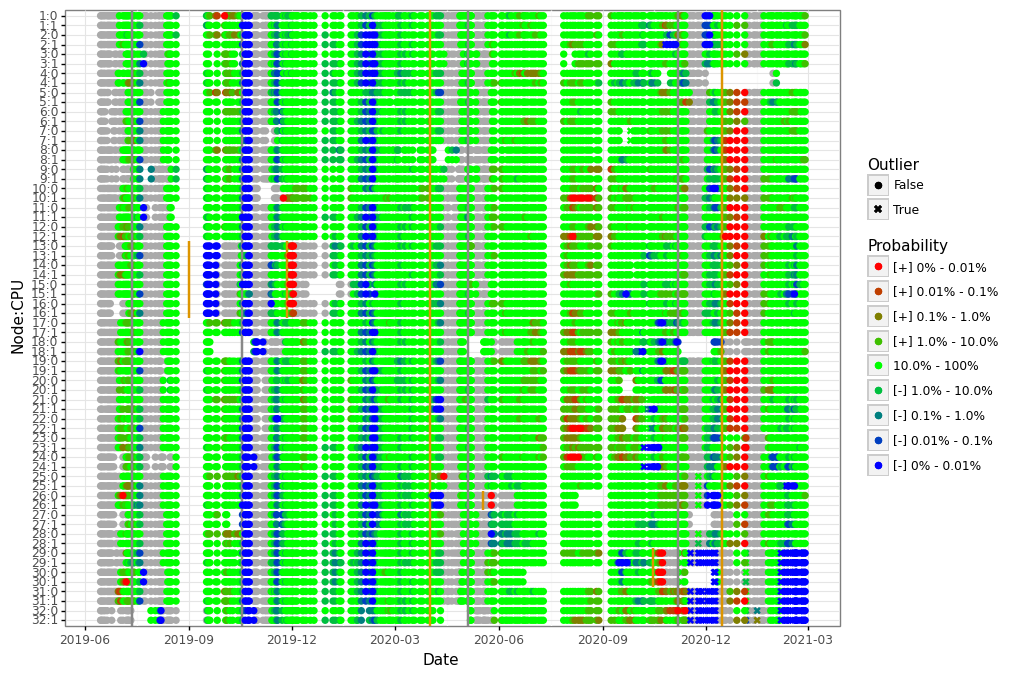

<ggplot: (8743863629951)>

In [13]:
plot = (nrt.plot_overview_windowed(tmp, changelog=changelog[changelog['date'] <= max_date], confidence=confidence, discretize=True)
    + xlab('Date')
    + scale_x_datetime(breaks=date_breaks('3 months'), labels=date_format('%Y-%m'))
    + theme(plot_title=element_blank())
)

plot.save('../img/slides/overview_windowed_dahu.pdf', width=10, height=8)
plot